In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


In [2]:
df = pd.read_csv('incoming_daily_till2023may_interpolated.csv')

In [3]:
df.shape

(881, 2)

# EDA

<AxesSubplot:>

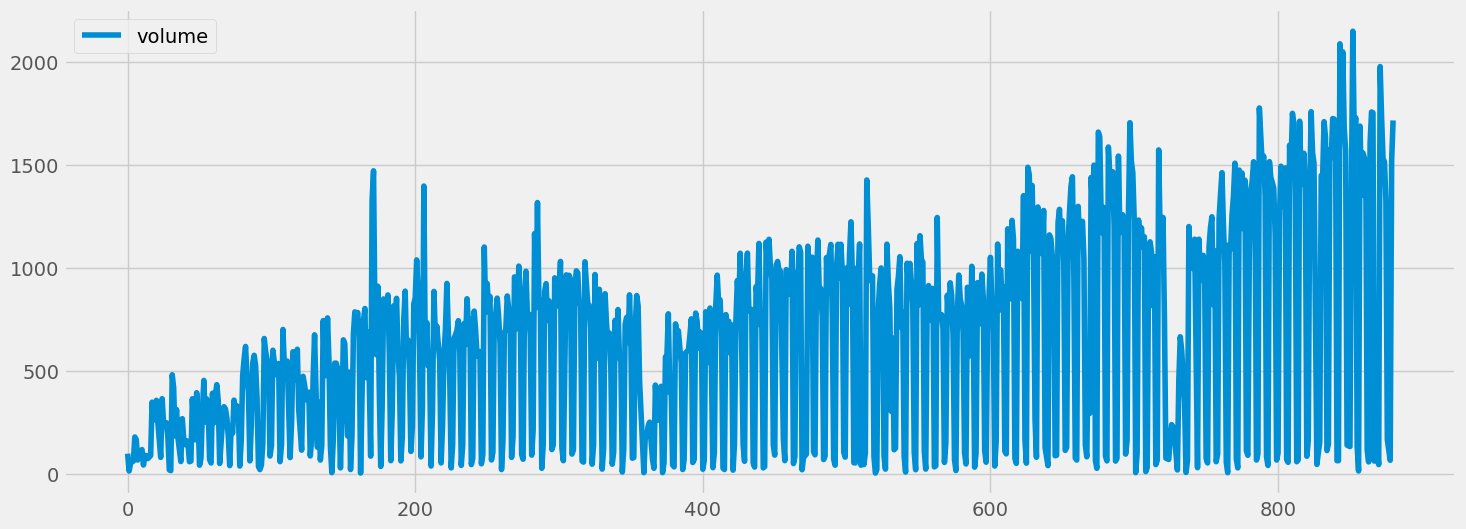

In [4]:
#plt.subplot(111)   #no of rows on y-axis,, 
df['volume'].plot(figsize=(16, 6), legend=True)

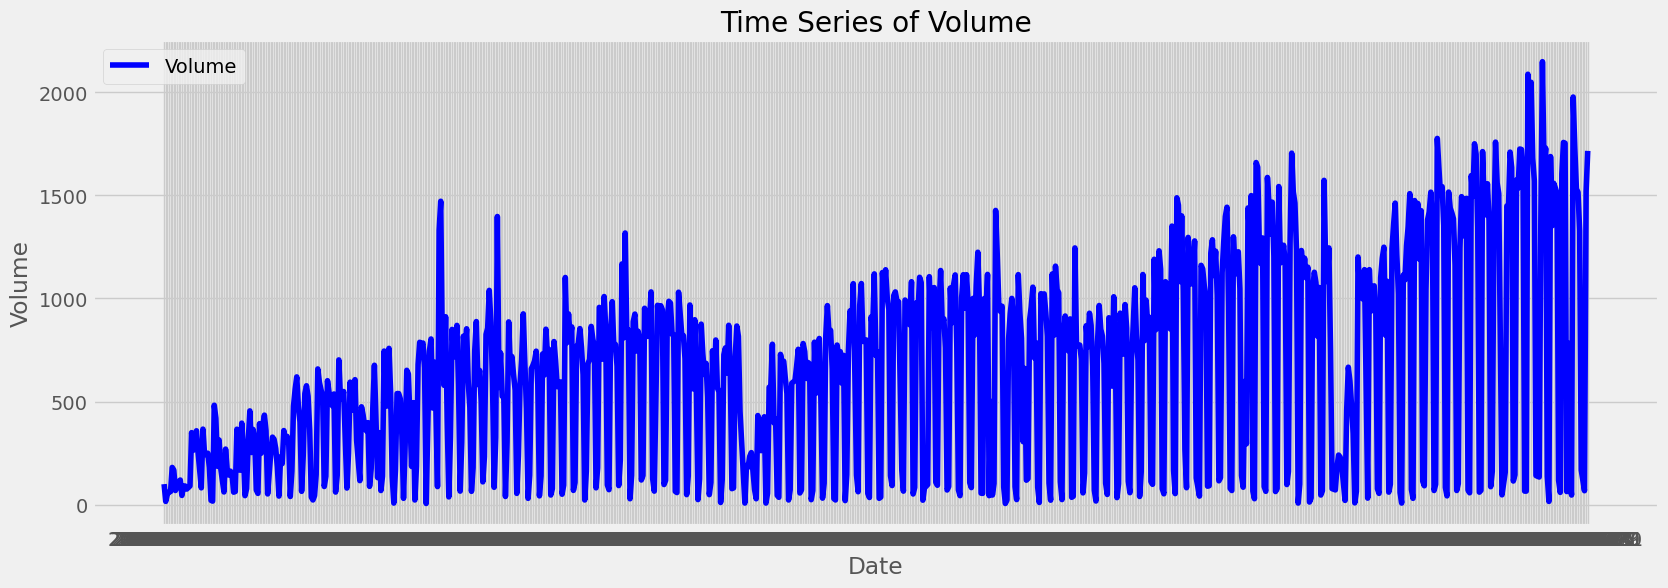

In [5]:
# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
plt.style.use('fivethirtyeight')

# Plotting the entire dataset
plt.figure(figsize=(18, 6))
plt.plot(df['date'], df['volume'], label='Volume', color='blue')
plt.title('Time Series of Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


The data seems to exhibit a clear seasonal pattern, which aligns with your mention of 365-day seasonality.
There's no immediately obvious increasing or decreasing trend, but the cyclical behavior (seasonality) is evident.
There are no obvious outliers, and the data seems consistent throughout.

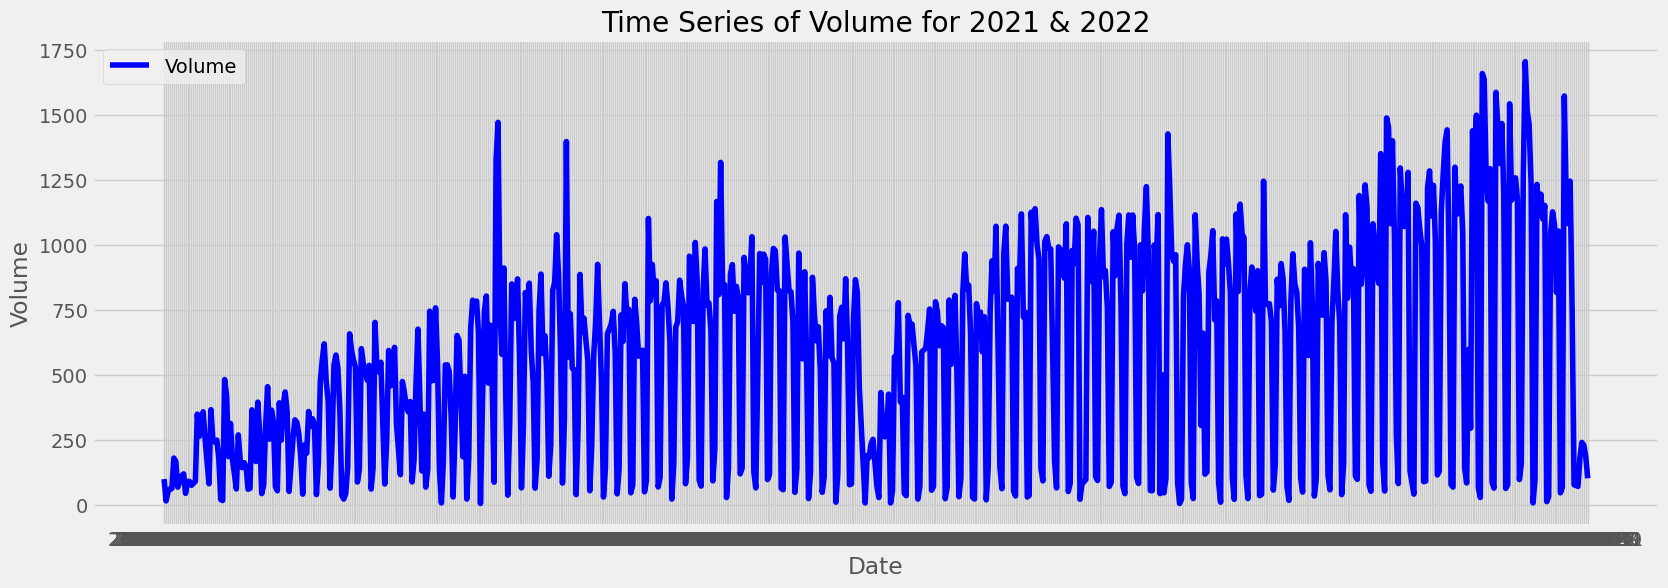

In [6]:
# Extracting data for two consecutive years (for example, 2021 and 2022)
df_subset = df[(df['date'] >= '2021-01-01') & (df['date'] <= '2022-12-31')]

# Plotting the subset data
plt.figure(figsize=(18, 6))
plt.plot(df_subset['date'], df_subset['volume'], label='Volume', color='blue')
plt.title('Time Series of Volume for 2021 & 2022')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


The plot for the years 2021 and 2022 provides a more detailed view of the seasonality:

The cyclical pattern, or seasonality, is more evident here. We can see repeated peaks and troughs throughout the two years, which suggests a consistent seasonal effect.
The spacing between peaks suggests a yearly seasonality, confirming the 365-day seasonality you mentioned.

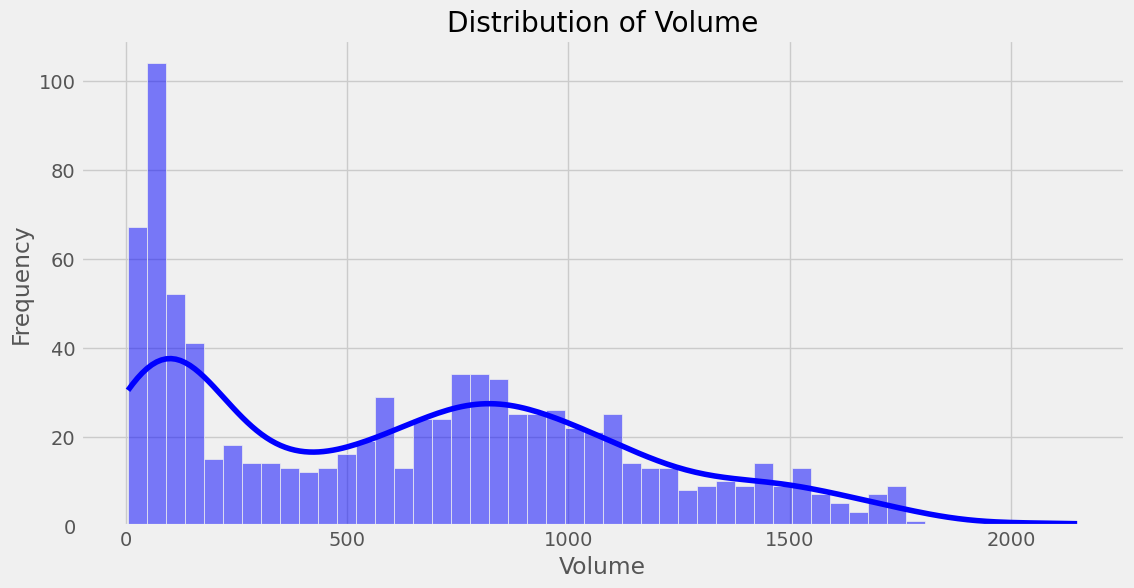

In [7]:
# Plotting the distribution of the 'volume' values
plt.figure(figsize=(12, 6))
sns.histplot(df['volume'], bins=50, color='blue', kde=True)
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The distribution appears to be somewhat right-skewed, indicating that there are more days with lower volumes and fewer days with very high volumes.
The Kernel Density Estimation (KDE) overlay provides a smooth estimate of the distribution and further emphasizes the skewness.
There don't appear to be any extreme outliers, but this can be further confirmed with box plots or other outlier detection methods if necessary.

To summarize the EDA:

The dataset exhibits clear seasonality with repeated patterns.
The distribution of volume values is somewhat right-skewed.
There are no missing values in the dataset.

# DATA PREPROCESSING

Scaling: Neural networks, including LSTMs, perform better with normalized or standardized input data. We can use MinMax scaling to scale our 'volume' values to a range between 0 and 1.

Sequence Data Preparation: For time series forecasting with LSTMs, we need to structure our dataset into input-output samples where one or more time steps are used as input to predict one or more future time steps.

In [8]:
from sklearn.preprocessing import MinMaxScaler
# Loading the dataset again
df = pd.read_csv('incoming_daily_till2023may_interpolated.csv')
df['date'] = pd.to_datetime(df['date'])

# Scaling the 'volume' column betwn 0 and 1
volume_values = df['volume'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(volume_values)


# Defining the create_sequences function again
def create_sequences(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        X.append(seq[:-1])
        y.append(seq[-1])

    return np.array(X), np.array(y)


# Defining sequence length based on the seasonality
SEQ_LENGTH = 365
# Creating sequences with a length of 365 days
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Splitting data into training and test sets (80-20 split)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((412, 364, 1), (412, 1), (104, 364, 1), (104, 1))

Scaling: I was scaling the 'volume' values to a range between 0 and 1 using MinMax scaling.

Sequence Data Preparation: I was converting the time series data into input-output sequences suitable for LSTM training, using a sequence length of 365 days (since you mentioned a seasonality of 365 days).
Data Splitting: I was splitting the data into training and test sets using an 80-20 split.

We've scaled the 'volume' values to be between 0 and 1.
We've structured the dataset into input-output sequences suitable for LSTM training. Each input sequence has a length of 364 days, and the corresponding output is the next day's volume.
The data has been split into training and test sets using an 80-20 split.
The shapes of the data arrays are:

Training data (input): 412 sequences, each of 364 days
Training data (output): 412 values (next day's volume for each sequence)
Test data (input): 104 sequences, each of 364 days
Test data (output): 104 values

We defined our sequence length as 365, given the yearly seasonality you mentioned.
For each sequence of 365 days, the first 364 days serve as the input, and the next day's value serves as the output (the value to be predicted).
Sequences are particularly useful for time series forecasting with LSTMs, as they allow the model to learn from past data (input sequence) to predict future values (output).

# LSTM MODEL BUILDING

Model Architecture: We'll define an LSTM model with the following layers:
An LSTM layer
A Dense (fully connected) layer for the output
Training: We'll train the LSTM model on the prepared data.
Evaluation: After training, we'll evaluate the model's performance on the test set.

In [9]:
import torch
import torch.nn as nn

# Define the LSTM model again
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch 
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.linear(out[:, -1, :])
        return out

# Hyperparameters for the LSTM model
input_dim = 1  # input dimension
hidden_dim = 64  # number of hidden states in LSTM
num_layers = 1  # number of LSTM layers
output_dim = 1  # output dimension

model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model


LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

We have successfully defined the LSTM model architecture. Here's a summary of the model:

LSTM Layer: This layer consists of LSTM units that can learn and remember patterns over long sequences. It has an input dimension of 1 (since we're predicting based on a single feature: volume) and 64 hidden states.

Fully Connected (Linear) Layer: This layer produces the output from the LSTM's last hidden state. It has an output dimension of 1 because we're predicting a single value: volume for the next day.

The next steps involve:

Specifying the loss function (Mean Squared Error, since it's a regression problem).
Choosing an optimizer (like Adam or SGD).
Training the model using the training data.
Evaluating the model's performance on the test set.

TRAINING THE MODEL


Loss Function: We'll use Mean Squared Error (MSE) as the loss function since this is a regression problem.
Optimizer: We'll use the Adam optimizer.
Training Loop: We'll define a training loop where we feed the training data to the model, compute the loss, perform backpropagation, and update the model weights.

Epoch [10/100], Loss: 0.0892
Epoch [20/100], Loss: 0.0533
Epoch [30/100], Loss: 0.0481
Epoch [40/100], Loss: 0.0485
Epoch [50/100], Loss: 0.0478
Epoch [60/100], Loss: 0.0475
Epoch [70/100], Loss: 0.0474
Epoch [80/100], Loss: 0.0472
Epoch [90/100], Loss: 0.0470
Epoch [100/100], Loss: 0.0467


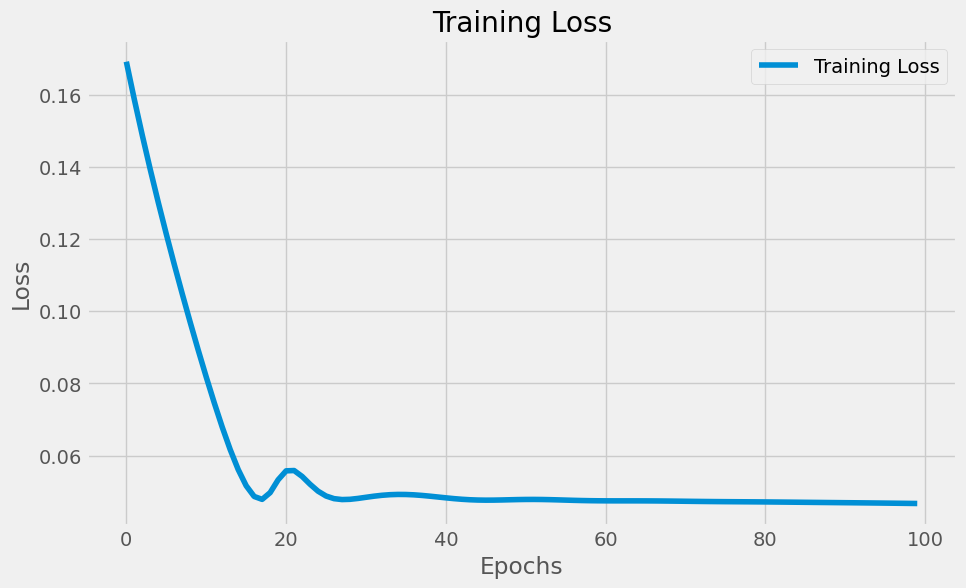

In [10]:
# Hyperparameters and utilities for training
learning_rate = 0.001
epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert dataset to PyTorch tensors
X_train_tensors = torch.Tensor(X_train)
y_train_tensors = torch.Tensor(y_train)
X_test_tensors = torch.Tensor(X_test)
y_test_tensors = torch.Tensor(y_test)

# Training loop
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensors)
    loss = loss_function(outputs, y_train_tensors)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


 The provided loss values indicate that the LSTM model has been trained and the loss has decreased over the epochs. This is a good sign, as it indicates that the model is learning from the training data.
 
 The loss starts at 0.1252 and decreases to 0.0476 by the 100th epoch.
The loss decreases sharply in the initial epochs and then starts to plateau as the epochs progress.
This behavior indicates that the model is learning from the training data, and as it continues training, the improvements become more incremental. The plateauing of the loss suggests that the model is converging.

Decreasing Loss: A decreasing training loss over epochs generally indicates that the model is learning and improving its ability to fit the training data. This is a good sign.
Plateauing Loss: If the loss plateaus (levels off and stops decreasing) for a significant number of epochs, it suggests that the model might have reached its limit in learning from the data, given its current architecture and hyperparameters.
Increasing Loss: A sudden increase in training loss might indicate that the model is diverging and is no longer learning. This could be due to reasons like a high learning rate.
Oscillations: Minor oscillations in the training loss are common, especially with certain optimizers or when the learning rate is high. However, large oscillations might indicate instability.
In the results you provided, the loss starts at a relatively higher value and decreases sharply in the initial epochs. As more epochs progress, the rate of decrease slows down, and the loss seems to plateau, suggesting that the model might be converging to a local minimum.

# EVALUATING MODEL ON TEST SET

We'll follow these steps:

Use the trained model to make predictions on the test data.
Convert the predictions back to their original scale using the MinMaxScaler's inverse transform.
Compare the predicted values with the actual values.
Calculate error metrics such as RMSE, MAE, etc.
Visualize the predicted vs. actual values.

Predict on Test Data: Use the trained model to make predictions on the test set.

In [11]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensors)


#Inverse Scaling: Convert the scaled predictions back to their original scale.

In [12]:
predicted_volume = scaler.inverse_transform(test_outputs.numpy())
actual_volume = scaler.inverse_transform(y_test)


In [16]:
mse = mean_squared_error(actual_volume, predicted_volume)

rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_volume, predicted_volume)
#print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
# Calculating Theil's U2 statistic
numerator = np.sum((predicted_volume - actual_volume) ** 2)
denominator = np.sum(actual_volume ** 2)
theils_u2 = np.sqrt(numerator / denominator)
print("Theil's u2:", theils_u2)

def compute_mape(actual, predicted):
    """Compute Mean Absolute Percentage Error (MAPE)"""
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = compute_mape(actual_volume, predicted_volume)
print("MAPE:", mape, "%")

RMSE: 761.4519932473173
MAE: 731.5911618746244
Theil's u2: 0.5996283746187473
MAPE: 327.4857908200877 %


A value of 0 indicates perfect forecasting accuracy, while values greater than 1 indicate less accurate forecasts.--theils u2

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['date'][-len(predicted_volume):], actual_volume, label='Actual', color='blue')
plt.plot(df['date'][-len(predicted_volume):], predicted_volume, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(df['date'][-len(predicted_volume):], actual_volume, label='Actual', color='blue')
plt.plot(df['date'][-len(predicted_volume):], predicted_volume, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting the residuals (errors) over time
residuals = actual_volume - predicted_volume
plt.figure(figsize=(15, 6))
plt.plot(df['date'][-len(residuals):], residuals, label='Residuals', color='green')
plt.axhline(0, color='black', linestyle='dashed')
plt.title('Residuals (Actual - Predicted) over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Residuals above the line: The model's predictions were below the actual values (under-predictions).
Residuals below the line: The model's predictions were above the actual values (over-predictions).
Residuals on the line: The model's predictions were exactly correct.
The goal in regression tasks is to have residuals that are randomly scattered around the zero line, indicating that there's no systematic bias in the predictions. If you see patterns or trends in the residuals, it suggests that the model might be missing some underlying structure or seasonality in the data.

In summary, the dotted line at zero is a reference to help assess how well the model is predicting the actual values, and whether there's any systematic bias in the predictions.

ADDITIONAL RESIDUALS

Additional visualizations can provide deeper insights into the model's performance. Here are some commonly used visualizations for regression tasks:

Prediction vs. Actual Plot: This scatter plot allows you to see how well the model's predictions match the actual values.
Histogram of Residuals: This plot helps in assessing the distribution of residuals/errors. Ideally, for a well-performing model, the residuals should be normally distributed.
Q-Q Plot (Quantile-Quantile plot): This is used to check if the residuals are normally distributed. If they lie on the 45-degree reference line, they are approximately normally distributed.
Autocorrelation Plot: This plot is used to check for any autocorrelation in the residuals.

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()


This plot provides insights into the distribution of the residuals. Ideally, they should be normally distributed.

In [ ]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals.flatten(), plot=plt)
plt.title('Q-Q Plot')
plt.grid(True)
plt.show()


This plot checks if residuals are normally distributed. The residuals should ideally lie on the 45-degree reference line.

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(residuals)
plt.title('Autocorrelation Plot')
plt.grid(True)
plt.show()


This plot checks if there's any autocorrelation in the residuals.

The autocorrelation plot (or correlogram) is a visual tool used to assess the autocorrelation in a time series data. Autocorrelation refers to the correlation of a time series with its own past and future values. Here's how to interpret and validate the autocorrelation plot:

X-axis: Represents the lag. A lag of 
�
k means the correlation between a value and its 
�
k-th previous value.

Y-axis: Represents the autocorrelation coefficient, which can range from -1 to 1. A value of 0 indicates no correlation, while values closer to 1 or -1 indicate strong positive or negative correlation, respectively.

Blue Lines (Confidence Intervals): These lines indicate the boundaries where correlation values are statistically significant. Any spike that goes beyond these lines is considered statistically significant.

Here's how to validate and interpret the plot:

Significant Spikes: If there are spikes outside the blue confidence intervals, especially at lower lags, it indicates that there's autocorrelation in the data. In the context of residuals from a model, significant autocorrelation suggests that the model failed to capture some structure or pattern in the data.

No Significant Spikes: If all spikes are within the blue confidence intervals, it suggests that the residuals are essentially white noise, which is a good sign. It means that the model has adequately captured the underlying structures and patterns in the data.

Decaying Pattern: A slow decay of the spikes suggests a trend in the time series. A sharp drop after a few lags might indicate a seasonal pattern.

Periodic Spikes: If you observe spikes at regular intervals, it might be indicative of seasonality in the data.

For model validation:

In the context of validating regression models (like LSTM), you ideally want your residuals (errors) to show no autocorrelation. If the residuals show autocorrelation, it means that there's some pattern in the errors that the model has failed to capture.

If the autocorrelation plot of residuals shows significant spikes, consider revisiting the model. It may benefit from additional features, a different architecture, or incorporating lagged values to capture the autocorrelation.

In summary, the autocorrelation plot provides insights into the nature of the time series and, when used on residuals, helps in assessing the adequacy of the model. If you've plotted the autocorrelation of the residuals, and there's significant autocorrelation at any lag, it's an indication that the model could potentially be improved.

# FORECASTING FOR NEXT 30 DAYS

In [ ]:
# 1. Start with the Last Sequence
last_sequence = scaled_data[-SEQ_LENGTH:]

forecasted_values = []

# 2. Predict the Next Value and 3. Update the Sequence
for _ in range(30):
    with torch.no_grad():
        # Convert sequence to tensor and reshape for LSTM
        input_sequence = torch.Tensor(last_sequence).view(1, SEQ_LENGTH, 1)
        
        # Get the prediction for the next day
        predicted_value = model(input_sequence)
        
        # Append the prediction to our list of forecasted values
        forecasted_values.append(predicted_value.numpy().flatten()[0])
        
        # Update the sequence with the predicted value
        last_sequence = np.append(last_sequence[1:], predicted_value)

# 5. Inverse Scaling
forecasted_volume = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# 6. Attach Dates
forecast_dates = pd.date_range(start=df['date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

forecasted_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Volume': forecasted_volume.flatten()
})

print(forecasted_df)


Forecasting the Next 30 Days
Start with the Last Sequence: Take the last sequence (of length SEQ_LENGTH) from the scaled dataset. This will serve as your initial input to the model.
Predict the Next Value:
Feed this sequence to the trained LSTM model.
Obtain a prediction for the next day.
Update the Sequence:
Append the predicted value to the end of the sequence.
Remove the first value from the sequence so that its length remains consistent with SEQ_LENGTH.
Repeat: Continue this process for 30 iterations to obtain predictions for the next 30 days.
Inverse Scaling: Convert the scaled predictions back to the original volume scale using the inverse transformation of the MinMaxScaler.
Attach Dates: Generate the corresponding dates for these forecasted values, starting from the day after the last date in your dataset.

In [ ]:
import matplotlib.pyplot as plt

# Setting up the plot
plt.figure(figsize=(15, 7))

# Plotting actual data
plt.plot(df['date'], df['volume'], label='Actual', color='blue')

# Plotting the forecasted data
plt.plot(forecasted_df['Date'], forecasted_df['Forecasted Volume'], label='Forecasted', color='red', linestyle='dashed', marker='o')

# Highlighting the forecasted section for clarity
plt.axvspan(df['date'].iloc[-1], forecasted_df['Date'].iloc[-1], color='gray', alpha=0.1)

plt.title('Actual vs Forecasted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
